# Demonstration on one single image


In [ ]:
import matplotlib.pyplot as plt
import cv2
import os

from common.blurrer import gen_gaussian_kernel, gen_motion_kernel, gen_box_kernel

def test_filter(deblurrer, image_path: str, save_path: str, provide_kernel: bool = False, save: bool = False):
    os.makedirs(save_path, exist_ok=True)
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found at {image_path}")
    
    if save:
        cv2.imwrite(save_path / "original_image.png", image)

    blur_types = [
        {'type': 'gaussian', 'size': 15, 'sigma': 3.0},
        {'type': 'motion', 'size': 15, 'length': 10, 'angle': 45},
        {'type': 'box', 'size': 5},
    ]

    filter_name = deblurrer.get_name()

    for blur_type in blur_types:
        if blur_type['type'] == 'gaussian':
            kernel = gen_gaussian_kernel(blur_type['size'], blur_type['sigma'])
        elif blur_type['type'] == 'motion':
            kernel = gen_motion_kernel(blur_type['size'], blur_type['length'], blur_type['angle'])
        elif blur_type['type'] == 'box':
            kernel = gen_box_kernel(blur_type['size'])

        blurred = cv2.filter2D(image, -1, kernel)
        if save:
            cv2.imwrite(save_path / f"{filter_name}_{blur_type["type"]}_blurred.png", blurred)
        if provide_kernel:
            deblurred_wkernel = deblurrer.deblur(blurred, kernel)
        
        deblurred = deblurrer.deblur(blurred)

        if save:
            cv2.imwrite(save_path / f"{filter_name}_{blur_type["type"]}_deblurred.png", deblurred)

        if provide_kernel:
            fig, axes = plt.subplots(1, 4, figsize=(15, 5))

            axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            axes[0].set_title('Original')
            axes[1].imshow(cv2.cvtColor(deblurred_wkernel, cv2.COLOR_BGR2RGB))
            axes[1].set_title(f'Deblurred {filter_name} wkernel')
            axes[2].imshow(cv2.cvtColor(deblurred, cv2.COLOR_BGR2RGB))
            axes[2].set_title(f'Deblurred {filter_name} nokernel')
            axes[3].imshow(cv2.cvtColor(blurred, cv2.COLOR_BGR2RGB))
            axes[3].set_title(f'Blurred ({blur_type["type"]})')
        else:
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))

            axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            axes[0].set_title('Original')
            axes[1].imshow(cv2.cvtColor(deblurred, cv2.COLOR_BGR2RGB))
            axes[1].set_title(f'Deblurred ({blur_type["type"]}) - {filter_name}')
            axes[2].imshow(cv2.cvtColor(blurred, cv2.COLOR_BGR2RGB))
            axes[2].set_title(f'Blurred ({blur_type["type"]})')

        for ax in axes:
            ax.axis('off')
        plt.show()

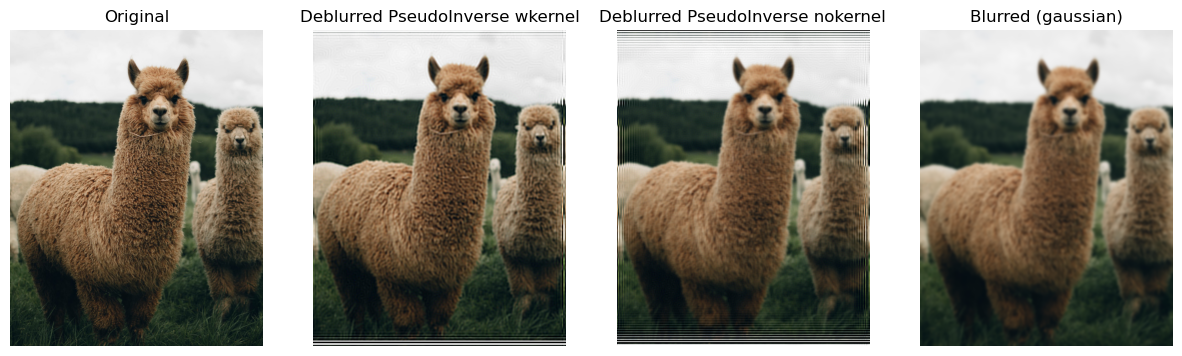

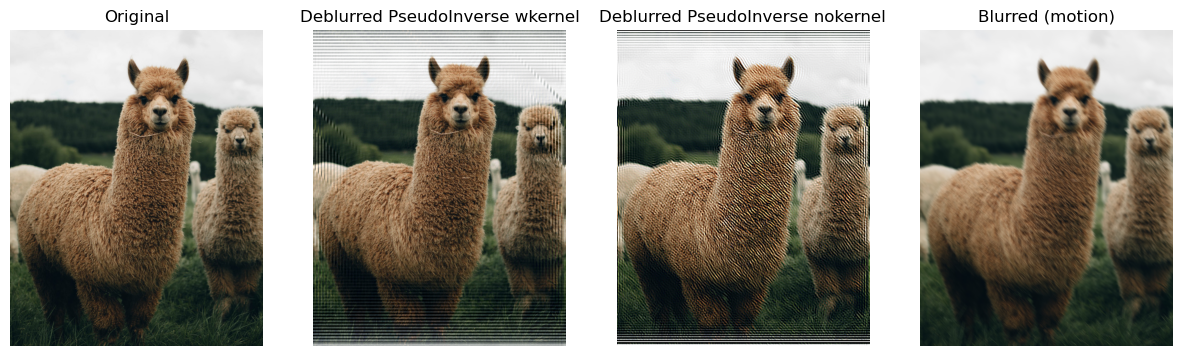

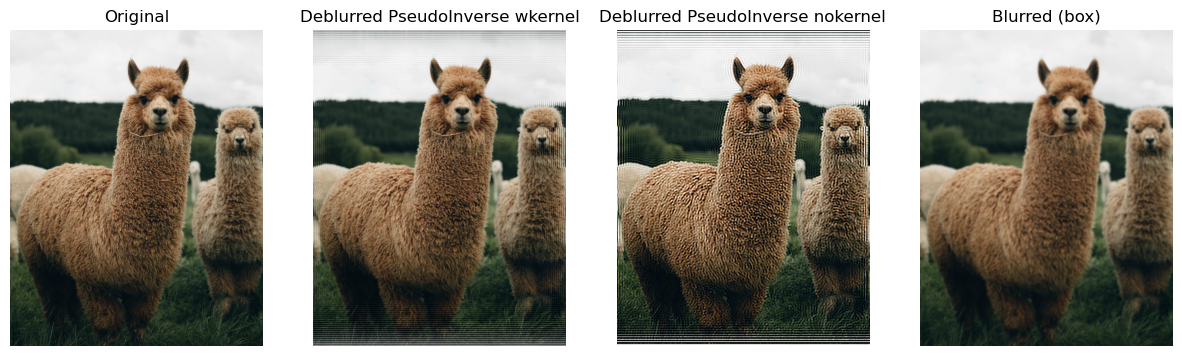

In [ ]:
from common.deblurrers import PseudoInverseDeblurrer
from common.config import TEST_ORIGINAL_DIR, TEST_DEBLURRED_INVERSE_DIR, TEST_DEBLURRED_WIENER_DIR, TEST_DEBLURRED_DEBLURGANV2_DIR, TEST_DEBLURRED_MPRNET_DIR

pseudo_deblurrer = PseudoInverseDeblurrer(regularization_lambda=1e-3)
test_filter(
    deblurrer=pseudo_deblurrer, 
    image_path=TEST_ORIGINAL_DIR / "00000" / "000000845.png", 
    save_path=TEST_DEBLURRED_INVERSE_DIR, provide_kernel=True)

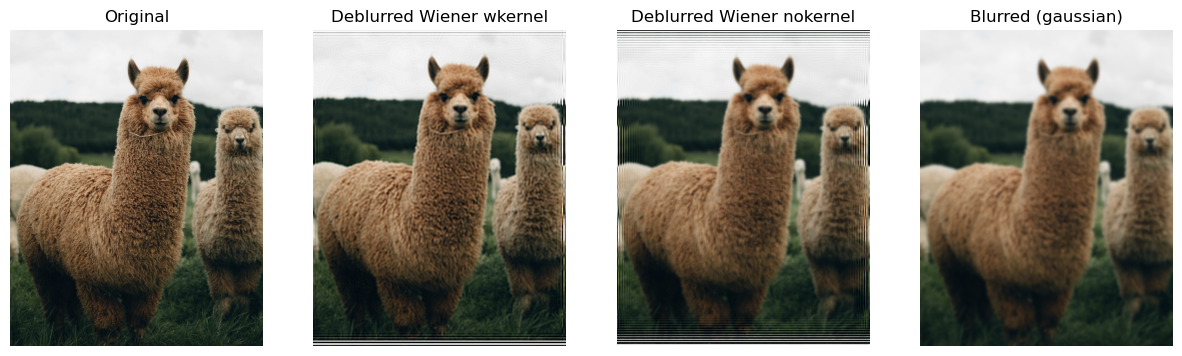

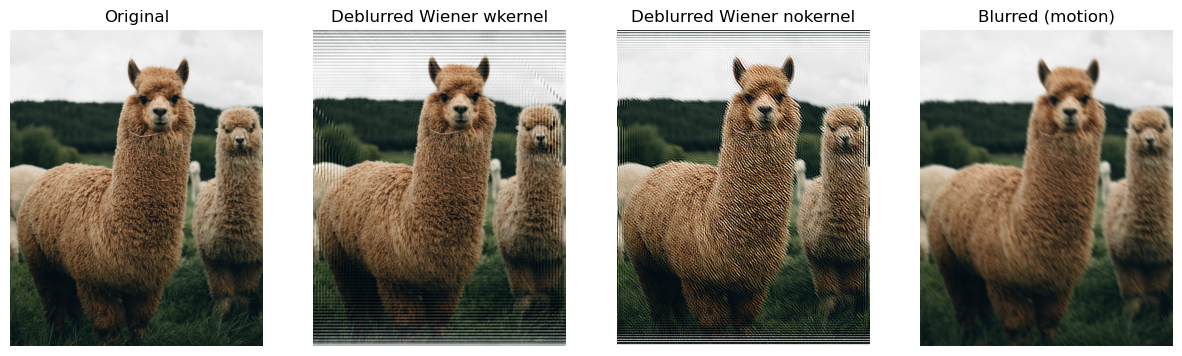

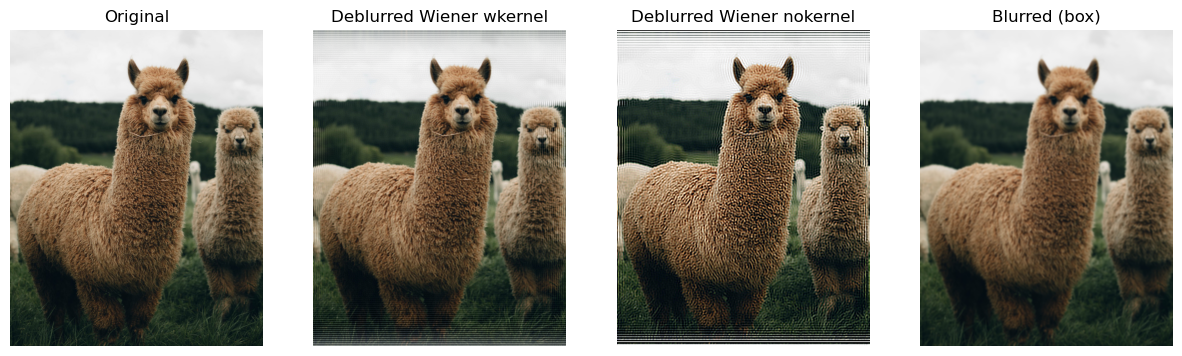

In [3]:
from common.deblurrers import WienerDeblurrer

wiener_deblurrer = WienerDeblurrer(K=1e-3)
test_filter(wiener_deblurrer, image_path, save_path, provide_kernel=True)

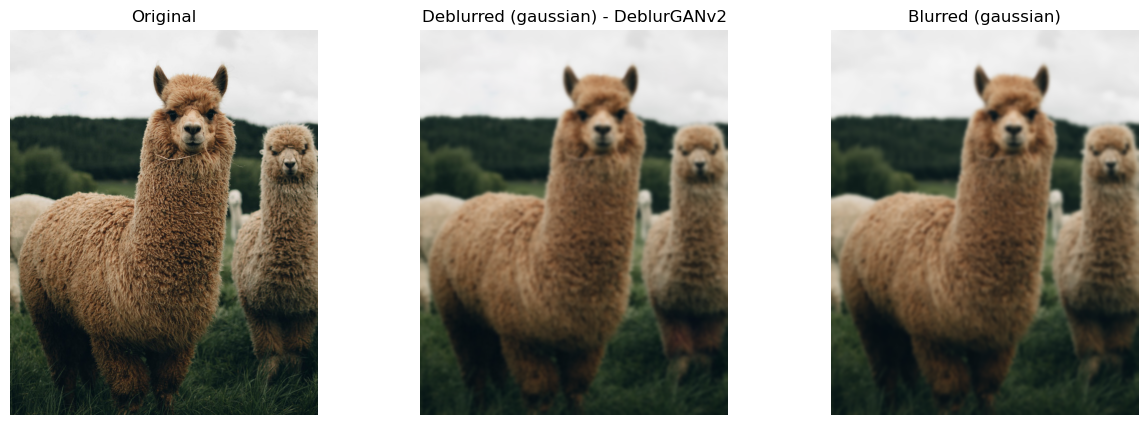

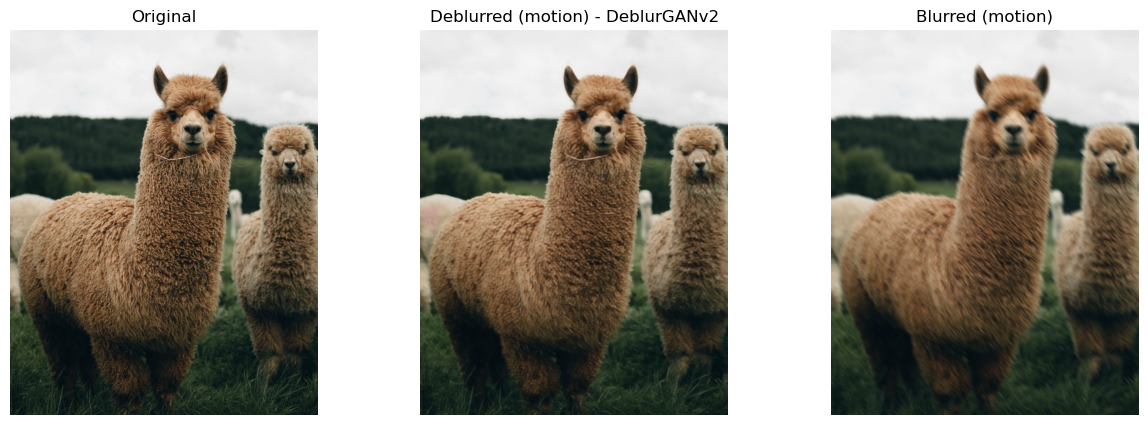

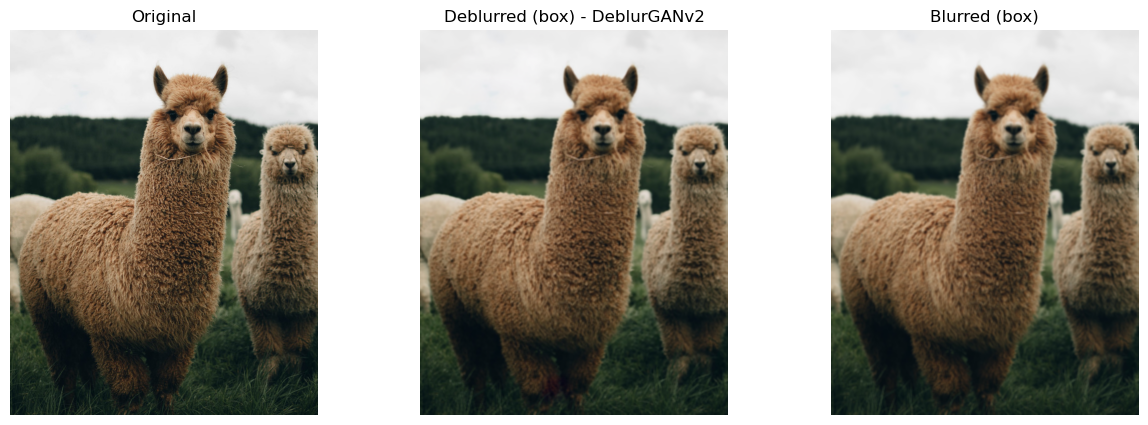

In [4]:
from common.deblurrers import DeblurGANv2Deblurrer
from common.config import OFFICIAL_DEBLURGANV2_WEIGHTS

deblurganv2_deblurrer = DeblurGANv2Deblurrer(
    weights_path=OFFICIAL_DEBLURGANV2_WEIGHTS
)
test_filter(deblurganv2_deblurrer, image_path, save_path)

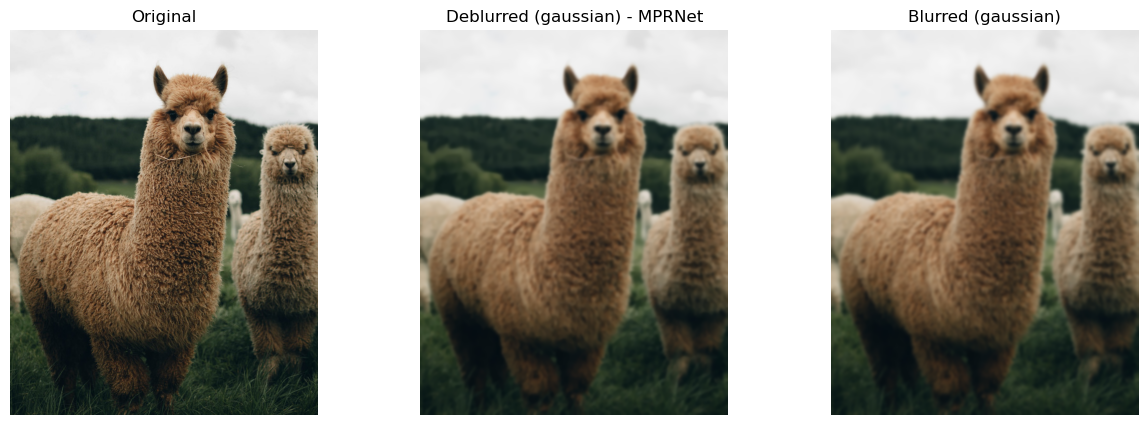

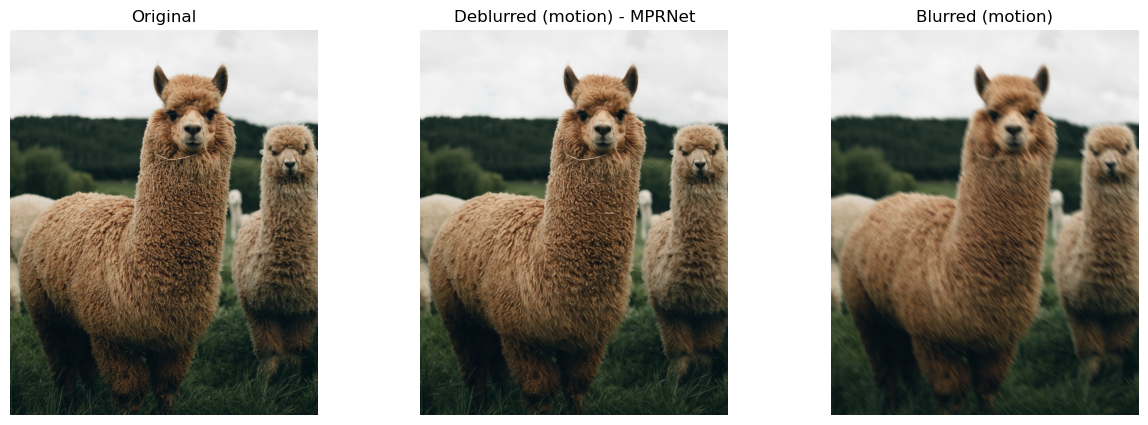

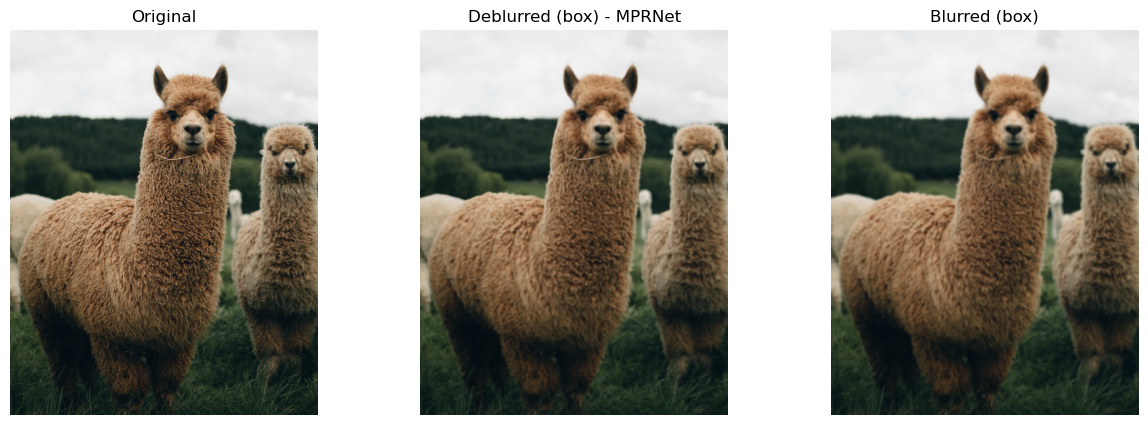

In [5]:
from common.deblurrers import MPRNetDeblurrer
from common.config import OFFICIAL_MPRNET_WEIGHTS

mprnet_deblurrer = MPRNetDeblurrer(
    weights_path=OFFICIAL_MPRNET_WEIGHTS
)
test_filter(mprnet_deblurrer, image_path, save_path)

# Generation of the deblurred/


In [1]:
import pandas as pd
from tqdm import tqdm
import cv2
import os

from pathlib import Path
from pandas import DataFrame

from common.deblurrers import Deblurrer
from common.config import BLUR_TYPES, TEST_BLURRED_DIR

def deblur(
        deblurrer: Deblurrer,
        input_path: Path, 
        output_path: Path, 
        kernel_df: DataFrame = None,
        sample: int = None,
        description: str = ""
    ):
    os.makedirs(output_path, exist_ok=True)

    images_paths = sorted(list(input_path.glob("*.png")))
    if sample:
        images_paths = images_paths[:sample]

    for img_path in tqdm(images_paths, desc=description):
        image = cv2.imread(img_path)
        if image is None:
            print("Could not read the image")
            continue

        img_name = img_path.name

        if kernel_df:
            kernel = kernel_df.loc[kernel_df["key"] == img_name.replace(".png", ""), "kernel"]
            deblurred = deblurrer.deblur(image, kernel)
        else:
            deblurred = deblurrer.deblur(image)

        cv2.imwrite(output_path / img_name, deblurred)

def gen_dataset(
        deblurrer: Deblurrer,
        output_path: Path,
        input_path: Path = TEST_BLURRED_DIR,
        kernel_dataset_path: Path = None,
        sample: int = None
    ):

    kernel_df = None

    if kernel_dataset_path:
        kernel_df = pd.read_parquet(kernel_dataset_path)

    for blur_type in BLUR_TYPES:
        deblur(
            deblurrer=deblurrer,
            input_path=input_path / blur_type,
            output_path=output_path / blur_type,
            kernel_df=kernel_df,
            sample=sample,
            description=f"Deblur: {blur_type:<8}\t"
        )

In [2]:
from common.deblurrers import PseudoInverseDeblurrer
from common.config import TEST_DEBLURRED_DIR

pseudo_deblurrer = PseudoInverseDeblurrer(regularization_lambda=1e-3)

gen_dataset(
    deblurrer=pseudo_deblurrer,
    output_path=TEST_DEBLURRED_DIR / pseudo_deblurrer.get_name(),
    sample=10
)

Deblur: motion  	: 100%|██████████| 10/10 [00:09<00:00,  1.08it/s]


In [ ]:
# gen_dataset(
#     deblurrer=pseudo_deblurrer,
#     output_path=TEST_DEBLURRED_DIR / pseudo_deblurrer.get_name(),
#     kernel_dataset_path=,
#     sample=10
# )